In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.exceptions import ConvergenceWarning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping

from scipy import stats
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import random
random.seed()
from math import ceil

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Data Preprocessing

In [ ]:
def data_overview(df): 
  print('====== First 5 rows ======')
  print(df.head())
  print('\n====== Shape ======')
  print(df.shape)
  print('\n====== Info======')
  print(df.info())
  print('\n====== Stats description ======')
  print(df.describe())
  print('\n====== Check missing value ======')
  print(df.isnull().sum())

In [ ]:
sales = pd.read_csv('sales.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [ ]:
data_overview(sales)

====== First 5 rows ======
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

====== Shape ======
(2935849, 6)

====== Info======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None

====== Stats description ======
       date_block_num       sh

In [ ]:
# as we don't have many nan values, let's drop the 50 nan 
sales.dropna(inplace=True)
# check again
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
# other issues are the negative prices and negative number of items sold
# let's remove them 
sales = sales[sales['item_price'] >= 0]
sales = sales[sales['item_cnt_day'] >= 0]
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.928442e+06,2.928442e+06,2.928442e+06,2.928442e+06,2.928442e+06
mean,1.456969e+01,3.300302e+01,1.020008e+04,3.377036e+03,1.248342e+00
std,9.422964e+00,1.622541e+01,6.324257e+03,2.620693e+04,2.619608e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,4.190000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568900e+04,1.044670e+03,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.200000e+06,2.169000e+03


In [ ]:
data_overview(items)

====== First 5 rows ======
                                           item_name  id  category
0                       ! POWER IN glamor (PLAST.) D   0        40
1  ! ABBYY FineReader 12 Professional Edition Ful...   1        76
2                           *** In the glory (UNV) D   2        40
3                             *** BLUE WAVE (Univ) D   3        40
4                                  *** BOX (GLASS) D   4        40

====== Shape ======
(22170, 3)

====== Info======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_name  22170 non-null  object
 1   id         22170 non-null  int64 
 2   category   22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None

====== Stats description ======
                id      category
count  22170.00000  22170.000000
mean   11084.50000     46.290753
std     6400.07207     15.94

In [ ]:
data_overview(item_categories)

====== First 5 rows ======
   ID               item_category_name active_flag
0  25    Games - Accessories for games         NaN
1   5             Accessories - PSVita         NaN
2  62  Gifts - gadgets, robots, sports         NaN
3  15         Game consoles - XBOX 360         NaN
4  14           Game consoles - PSVita         NaN

====== Shape ======
(95, 3)

====== Info======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  95 non-null     int64 
 1   item_category_name  95 non-null     object
 2   active_flag         11 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB
None

====== Stats description ======
              ID
count  95.000000
mean   40.600000
std    24.358755
min     0.000000
25%    18.500000
50%    41.000000
75%    61.500000
max    83.000000

====== Check missing value ======
I

In [ ]:
data_overview(shops)

====== First 5 rows ======
  system_id                                   name  id active_flag
0   R395989                Voronezh TRC "Maksimir"   7           X
1   Q222502                       Zhukovsky Street  11           X
2    B70025  RostovNaDonu TRC "Megacenter Horizon"  39         NaN
3   U750976      ! Yakutsk Ordzhonikidze, 56 Franc   0         NaN
4   F831253                Shop Online Emergencies  12         NaN

====== Shape ======
(68, 4)

====== Info======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   system_id    68 non-null     object
 1   name         68 non-null     object
 2   id           68 non-null     int64 
 3   active_flag  8 non-null      object
dtypes: int64(1), object(3)
memory usage: 2.2+ KB
None

====== Stats description ======
              id
count  68.000000
mean   26.955882
std    17.869706
min     0.000000
25

In [ ]:
data_overview(shops)

====== First 5 rows ======
  system_id                                   name  id active_flag
0   R395989                Voronezh TRC "Maksimir"   7           X
1   Q222502                       Zhukovsky Street  11           X
2    B70025  RostovNaDonu TRC "Megacenter Horizon"  39         NaN
3   U750976      ! Yakutsk Ordzhonikidze, 56 Franc   0         NaN
4   F831253                Shop Online Emergencies  12         NaN

====== Shape ======
(68, 4)

====== Info======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   system_id    68 non-null     object
 1   name         68 non-null     object
 2   id           68 non-null     int64 
 3   active_flag  8 non-null      object
dtypes: int64(1), object(3)
memory usage: 2.2+ KB
None

====== Stats description ======
              id
count  68.000000
mean   26.955882
std    17.869706
min     0.000000
25

# Exploratory Data Analysis 

In [ ]:
sales['year'] = pd.to_datetime(sales['date']).dt.strftime('%Y')
sales['month'] = pd.to_datetime(sales['date']).dt.strftime('%m')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.00,1.0,2013,02
1,03.01.2013,0,25,2552,899.00,1.0,2013,03
3,06.01.2013,0,25,2554,1709.05,1.0,2013,06
4,15.01.2013,0,25,2555,1099.00,1.0,2013,01
5,10.01.2013,0,25,2564,349.00,1.0,2013,10


## Sales Plots

### By time period

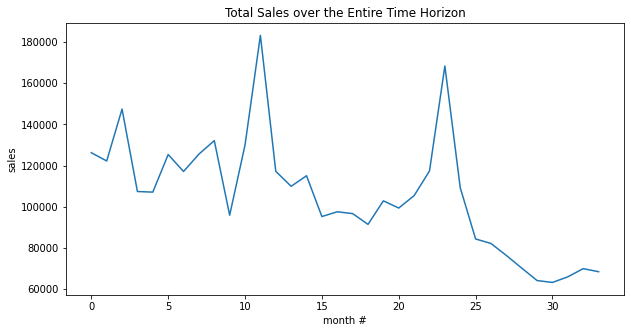

In [109]:
total = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
total.astype('float')
plt.figure(figsize=(10,5))
plt.title('Total Sales over the Entire Time Horizon')
plt.xlabel('month #')
plt.ylabel('sales')
plt.plot(total);

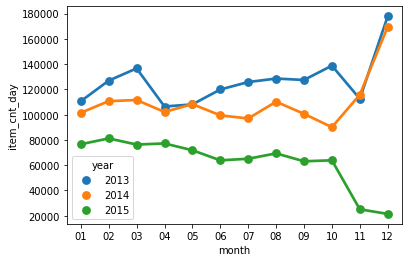

In [113]:
sales_agg = pd.DataFrame(sales.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=sales_agg)

In [111]:
# as seen in the plot above, we don't have the complete information 
# of sales in Nov and Dec of 2015, so let's exclude them and plot again
indexNames = sales_agg[(sales_agg['year']=='2015') & (sales_agg['month']>'10')].index
sales_agg.drop(indexNames,inplace = True)

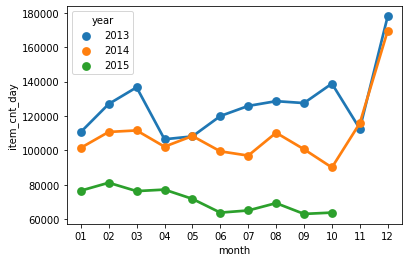

In [112]:
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=sales_agg)

### By shop

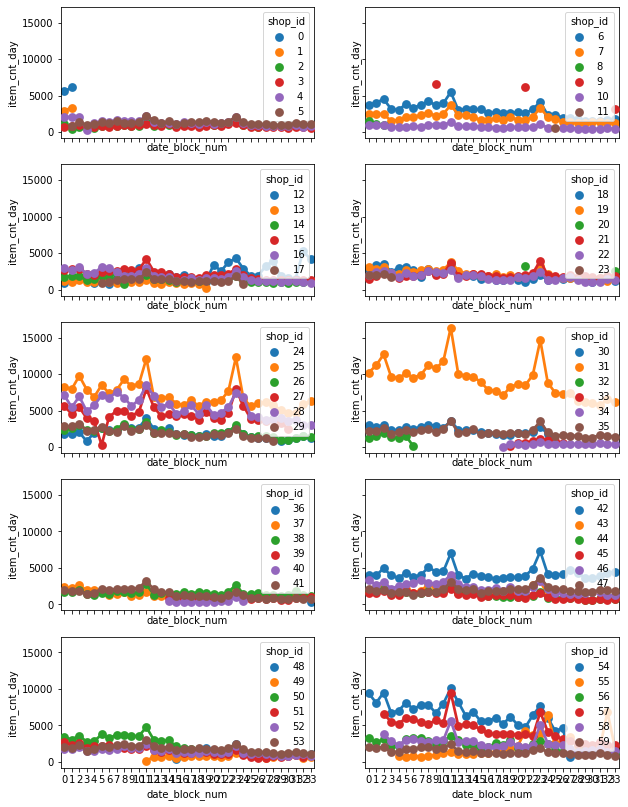

In [ ]:
sales_shop = pd.DataFrame(sales.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(10,14))
num_graph = 10
id_per_graph = ceil(sales_shop.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', 
                      data=sales_shop[np.logical_and(count*id_per_graph <= sales_shop['shop_id'], 
                      sales_shop['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

## Average Price Plots

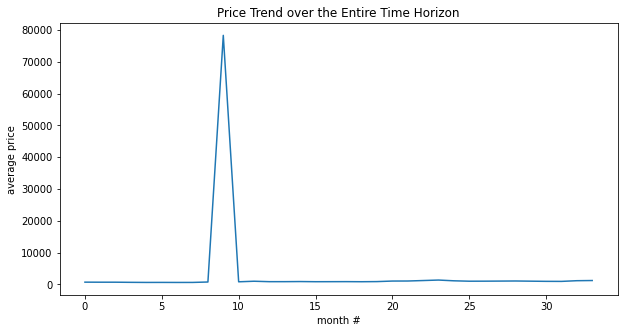

In [ ]:
prices = sales.groupby(["date_block_num"])["item_price"].mean()
prices.astype('float')
plt.figure(figsize=(10,5))
plt.title('Price Trend over the Entire Time Horizon')
plt.xlabel('month #')
plt.ylabel('average price')
plt.plot(prices);

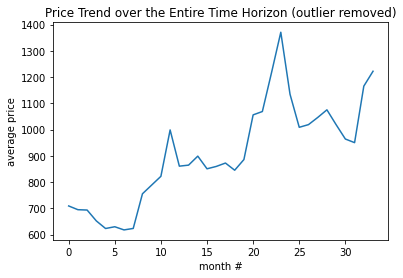

In [ ]:
# we see an unusual peak at month 9
# for now, let's drop it to better view the overall trend
prices = prices.drop([9])
plt.title('Price Trend over the Entire Time Horizon (outlier removed)')
plt.xlabel('month #')
plt.ylabel('average price')
plt.plot(prices);

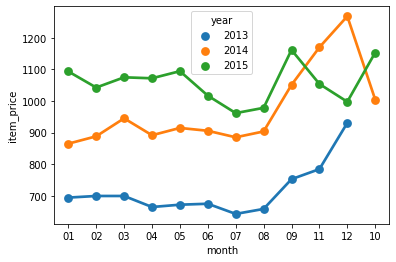

In [ ]:
prices_agg = pd.DataFrame(sales.groupby(['year','month'])['item_price'].mean().reset_index())
prices_agg = prices_agg.drop(prices_agg.index[9])
sns.pointplot(x='month', y='item_price', hue='year', data=prices_agg)

## Outlier Detection

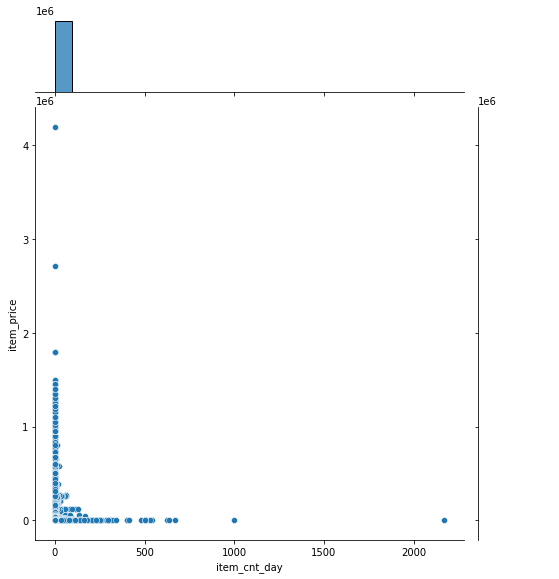

In [ ]:
sns.jointplot(x="item_cnt_day", y="item_price", data=sales, height=8)
plt.show()

In [ ]:
print('# of items summary:',sales.item_cnt_day.describe())
print('\n\nitem price summary:',sales.item_price.describe())

# of items summary: count    2.928442e+06
mean     1.248342e+00
std      2.619608e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


item price summary: count    2.928442e+06
mean     3.377036e+03
std      2.620693e+04
min      7.000000e-02
25%      2.490000e+02
50%      4.190000e+02
75%      1.044670e+03
max      4.200000e+06
Name: item_price, dtype: float64


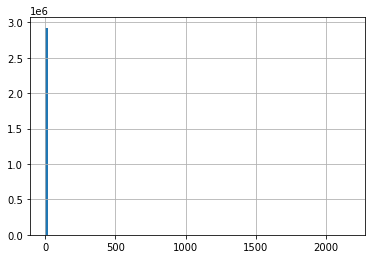

In [ ]:
sales.item_cnt_day.hist(bins=100)

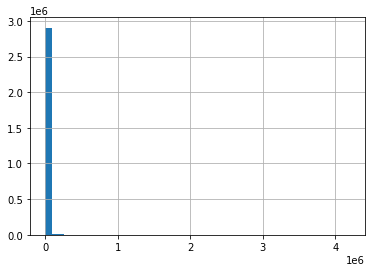

In [ ]:
sales.item_price.hist(bins=50)

Outliers: item_cnt_day > 150, price > 100,000

In [ ]:
print('Sales shape before remove outliers:', sales.shape)
sales = sales[sales['item_cnt_day'] <= 150]
sales = sales[sales['item_price'] <= 100000]
print('Sales shape after remove outliers:', sales.shape)

Sales shape before remove outliers: (2928442, 8)
Sales shape after remove outliers: (2909577, 8)


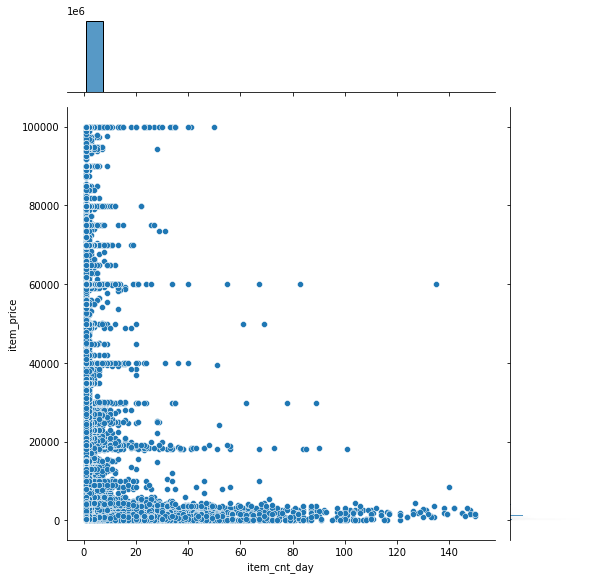

In [ ]:
sns.jointplot(x="item_cnt_day", y="item_price", data=sales, height=8)
plt.show()

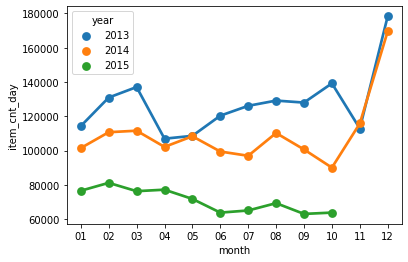

In [ ]:
sales_cleaned = pd.DataFrame(sales.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
indexNames = sales_cleaned[(sales_cleaned['year']=='2015') & (sales_cleaned['month']>'10')].index
sales_cleaned.drop(indexNames,inplace = True)
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=sales_cleaned)

# Model Training

In [ ]:
sales = sales[sales['shop_id'] != 0]

sales_pivot = sales.pivot_table(index = ['shop_id','item_id'],
                                 values = ['item_cnt_day'],
                                 columns = ['date_block_num'],
                                 fill_value = 0,aggfunc='sum')
sales_pivot.reset_index(inplace = True)
sales_pivot.head()

shop_id item_id item_cnt_day               ...                     
date_block_num                            0   1  2  3  4  ... 27 28 29 30 31 32 33
0                    1      27            1   0  0  0  0  ...  0  0  0  0  0  0  0
1                    1      29            1   0  0  0  0  ...  0  0  0  0  0  0  0
2                    1      30            0  10  0  0  0  ...  0  0  0  0  0  0  0
3                    1      31            0   4  0  0  0  ...  0  0  0  0  0  0  0
4                    1      32            7   3  0  0  0  ...  0  0  0  0  0  0  0

[5 rows x 36 columns]

In [ ]:
indices = sales_pivot[['shop_id','item_id']]
indices.head()

,shop_id,item_id
date_block_num,,
0,1,27
1,1,29
2,1,30
3,1,31
4,1,32


In [ ]:
sales_pivot.drop(['shop_id','item_id'],inplace = True, axis = 1)
sales_pivot = sales_pivot.rename(columns={'item_cnt_day':'monthly_sales'})
sales_pivot.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


monthly_sales                        ...                        
date_block_num            0   1  2  3  4  5  6  7   ... 26 27 28 29 30 31 32 33
0                          1   0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0
1                          1   0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0
2                          0  10  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0
3                          0   4  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0
4                          7   3  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0

[5 rows x 34 columns]

In [ ]:
# the first 33 months are for training
X_train = np.expand_dims(sales_pivot.values[:,:-1],axis = 2)

# the last column is our labels
y_train = sales_pivot.values[:,-1:]

# test set consists of all columns except the first
X_test = np.expand_dims(sales_pivot.values[:,1:],axis = 2)

print(X_train.shape,y_train.shape,X_test.shape)

(419860, 33, 1) (419860, 1) (419860, 33, 1)


In [ ]:
# create our LSTM model
model = Sequential()
model.add(LSTM(units = 64,input_shape = (33,1),activation='relu'))

# dropout set to be 40%
model.add(Dropout(0.4))
model.add(Dense(1))

# loss function is MSE
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# the model is fit for 10 training epochs with a batch size of 4096 each
trained = model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
103/103 [==============================] - 64s 618ms/step - loss: 3.2493 - mean_squared_error: 3.2493
Epoch 2/10
103/103 [==============================] - 66s 640ms/step - loss: 3.3025 - mean_squared_error: 3.3025
Epoch 3/10
103/103 [==============================] - 63s 614ms/step - loss: 2.7934 - mean_squared_error: 2.7934
Epoch 4/10
103/103 [==============================] - 63s 608ms/step - loss: 2.7832 - mean_squared_error: 2.7832
Epoch 5/10
103/103 [==============================] - 63s 615ms/step - loss: 2.6291 - mean_squared_error: 2.6291
Epoch 6/10
103/103 [==============================] - 64s 623ms/step - loss: 2.6420 - mean_squared_error: 2.6420
Epoch 7/10
103/103 [==============================] - 63s 615ms/step - loss: 2.6135 - mean_squared_error: 2.6135
Epoch 8/10
103/103 [==============================] - 64s 625ms/step - loss: 2.9545 - mean_squared_error: 2.9545
Epoch 9/10
103/103 [==============================] - 63s 613ms/step - loss: 2.2510 - mean_squar

# Prediction

In [ ]:
prediction = model.predict(X_test)

In [ ]:
prediction_df = pd.DataFrame(data=prediction)

In [ ]:
temp = [indices,prediction_df]

In [ ]:
prediction_df = pd.concat(temp,axis=1)

In [ ]:
prediction_df = prediction_df.rename(columns={('shop_id', ''): "shop_id", ('item_id', ''): "item_id" ,0:"predicted_monthly_sales"})

In [ ]:
prediction_df.head()

,shop_id,item_id,predicted_monthly_sales
0,1,27,0.094440
1,1,29,0.094440
2,1,30,0.088895
3,1,31,0.091257
4,1,32,0.092011


In [ ]:
prediction_df.describe()

,shop_id,item_id,predicted_monthly_sales
count,419860.000000,419860.000000,419860.000000
mean,31.711809,11461.199366,0.167818
std,16.779545,6132.971371,1.115308
min,1.000000,0.000000,-0.160096
25%,18.000000,6252.000000,0.091401
50%,30.000000,11618.000000,0.093413
75%,46.000000,16663.000000,0.117299
max,59.000000,22169.000000,545.421692


# Item Category Insights

Plot the sales in Novembers from 2013 to 2015 where the sales in 2015 is the predicted value, categorized by item cateory. 

The purpose is to see the trends of different categories, and to help develop detailed recommendations. 

In [77]:
# merge items, item_categories and prediction df to find out sales by cateory
items_df = items.rename(columns={'id':'item_id'})
items_df.head()
item_cat_df = item_categories.rename(columns={'ID':'item_id'})
item_cat_df.head()
prediction_item_cat = prediction_df.merge(items_df, left_on='item_id',right_on='item_id')
prediction_item_cat.head()

,shop_id,item_id,predicted_monthly_sales,item_name,category
0,1,27,0.094440,"007 Legends [PS3, Russian version]",19
1,2,27,0.092998,"007 Legends [PS3, Russian version]",19
2,3,27,0.093012,"007 Legends [PS3, Russian version]",19
3,4,27,0.092928,"007 Legends [PS3, Russian version]",19
4,5,27,0.092284,"007 Legends [PS3, Russian version]",19


In [78]:
prediction_item_cat = prediction_item_cat.merge(item_cat_df, left_on='item_id',right_on='item_id')
prediction_item_cat.head()

,shop_id,item_id,predicted_monthly_sales,item_name,category,item_category_name,active_flag
0,1,27,0.094440,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
1,2,27,0.092998,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
2,3,27,0.093012,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
3,4,27,0.092928,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
4,5,27,0.092284,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN


In [79]:
prediction_item_cat = prediction_item_cat.rename(columns={'predicted_monthly_sales':'monthly_sales'})

In [80]:
prediction_item_cat.head()

,shop_id,item_id,monthly_sales,item_name,category,item_category_name,active_flag
0,1,27,0.094440,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
1,2,27,0.092998,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
2,3,27,0.093012,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
3,4,27,0.092928,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN
4,5,27,0.092284,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN


In [81]:
prediction_item_cat['date_block_num'] = 34
prediction_item_cat.head()

,shop_id,item_id,monthly_sales,item_name,category,item_category_name,active_flag,date_block_num
0,1,27,0.094440,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN,34
1,2,27,0.092998,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN,34
2,3,27,0.093012,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN,34
3,4,27,0.092928,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN,34
4,5,27,0.092284,"007 Legends [PS3, Russian version]",19,Games MAC - Digital,NaN,34


In [82]:
# merge items, item_categories and historical sales in Novembers 2013 and 2014 df 
# to find out historical sales by cateory
nov_sales = sales[(sales['date_block_num']==10) | (sales['date_block_num']==22)]
nov_sales = nov_sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().reset_index()
nov_sales = nov_sales.rename(columns={'item_cnt_day':'monthly_sales'})
# nov_sales.head()

history_item_cat = nov_sales.merge(items_df, left_on='item_id',right_on='item_id')
history_item_cat.head()

,date_block_num,shop_id,item_id,monthly_sales,item_name,category
0,10,2,33,2.0,1+1 (BD),37
1,10,7,33,1.0,1+1 (BD),37
2,10,10,33,1.0,1+1 (BD),37
3,10,22,33,2.0,1+1 (BD),37
4,10,27,33,1.0,1+1 (BD),37


In [83]:
history_item_cat = history_item_cat.merge(item_cat_df, left_on='item_id',right_on='item_id')

In [84]:
history_item_cat.head()

,date_block_num,shop_id,item_id,monthly_sales,item_name,category,item_category_name,active_flag
0,10,2,33,2.0,1+1 (BD),37,Payment cards - Live!,NaN
1,10,7,33,1.0,1+1 (BD),37,Payment cards - Live!,NaN
2,10,10,33,1.0,1+1 (BD),37,Payment cards - Live!,NaN
3,10,22,33,2.0,1+1 (BD),37,Payment cards - Live!,NaN
4,10,27,33,1.0,1+1 (BD),37,Payment cards - Live!,NaN


In [85]:
cat_insights = history_item_cat.append(prediction_item_cat)

In [86]:
cat_insights.head()

,date_block_num,shop_id,item_id,monthly_sales,item_name,category,item_category_name,active_flag
0,10,2,33,2.0,1+1 (BD),37,Payment cards - Live!,NaN
1,10,7,33,1.0,1+1 (BD),37,Payment cards - Live!,NaN
2,10,10,33,1.0,1+1 (BD),37,Payment cards - Live!,NaN
3,10,22,33,2.0,1+1 (BD),37,Payment cards - Live!,NaN
4,10,27,33,1.0,1+1 (BD),37,Payment cards - Live!,NaN


In [97]:
cat_name_grouped = cat_insights.groupby(['date_block_num','category'])['item_category_name'].apply(lambda x: ','.join(x)).reset_index()

In [99]:
cat_name_grouped.head()

,date_block_num,category,item_category_name
0,10,19,"Games MAC - Digital,Games MAC - Digital"
1,10,30,"Games PC - Additional publications,Games PC - ..."
2,10,37,"Payment cards - Live!,Payment cards - Live!,Pa..."
3,10,40,"Games PC - Standard Edition,Games PC - Standar..."
4,10,43,"Music - CD of local production,Music - CD of l..."


In [104]:
cat_insights_grouped = cat_insights.groupby(['date_block_num','category'])['item_category_name','monthly_sales'].sum().reset_index()
cat_insights_grouped = cat_insights_grouped.merge(cat_name_grouped, how = 'inner')

In [117]:
cat_insights_grouped.head()

,date_block_num,category,monthly_sales,item_category_name
0,10,19,2.0,"Games MAC - Digital,Games MAC - Digital"
1,10,30,7.0,"Games PC - Additional publications,Games PC - ..."
2,10,37,50.0,"Payment cards - Live!,Payment cards - Live!,Pa..."
3,10,40,239.0,"Games PC - Standard Edition,Games PC - Standar..."
4,10,43,17.0,"Music - CD of local production,Music - CD of l..."


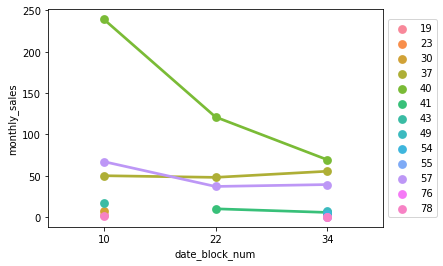

In [119]:
g = sns.pointplot(x='date_block_num', y='monthly_sales', hue='category', data=cat_insights_grouped)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [120]:
# it can be seen that sales in category 37 and 57 is expected to increase in 2015
# despite the majority of other items are expected to have decreasing sales 
cat1 = cat_insights_grouped[cat_insights_grouped['category']==37]
cat2 = cat_insights_grouped[cat_insights_grouped['category']==57]

In [122]:
# let's see what the corresponding category names are 
cat1

,date_block_num,category,monthly_sales,item_category_name
2,10,37,50.000000,"Payment cards - Live!,Payment cards - Live!,Pa..."
7,22,37,48.000000,"Payment cards - Live!,Payment cards - Live!,Pa..."
14,34,37,55.369394,"Games PC - Digital,Games PC - Digital,Games PC..."


In [123]:
cat2

,date_block_num,category,monthly_sales,item_category_name
5,10,57,67.000000,"Books - artbook, encyclopedia,Books - artbook,..."
10,22,57,37.000000,"Books - artbook, encyclopedia,Books - artbook,..."
21,34,57,39.310124,"Books - Fiction,Books - Fiction,Books - Fictio..."
